In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.shape

(223453, 9)

### 1. Podela na trening, test, i validacioni skup

In [5]:
# data.head()

In [5]:
X = data['comment_text']
y = data['target']

In [6]:
X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, stratify=y_train_validation, random_state=7)

In [7]:
X_train.shape, X_validation.shape, X_test.shape

((119770,), (29943,), (73740,))

In [8]:
y_train.shape, y_validation.shape, y_test.shape

((119770,), (29943,), (73740,))

### 2. Tokenizacija I vektorizacija teksta

In [9]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [10]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_binary.pickle')

In [11]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 201164


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [12]:
X_train = to_sequence(X_train, max_len, tokenizer)
X_test = to_sequence(X_test, max_len, tokenizer)
X_validation = to_sequence(X_validation, max_len, tokenizer)

In [13]:
X_train.shape, X_test.shape, X_validation.shape

((119770, 100), (73740, 100), (29943, 100))

In [14]:
X_train_validation = to_sequence(X_train_validation, max_len, tokenizer)

Kreira se matrica ugnjezdavanja

In [15]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

### 3. Selekcija i evaluacija modela

In [16]:
# Posto su klasa nebalansirane, potrebno je dodeliti im tezine
# tako da se vise kaznjava pogresna klasifikacija manjinske klase

weights = get_weights(y_train_validation)
weights

{0: 0.5558967465969598, 1: 4.97253221735087}

Za podešavanje hiperparametara koristiće se randomizovana unakrsna validacija i keras wrapper 

In [17]:
random_cv = randomized_search_cv(X_train_validation, y_train_validation, weights, embedding_matrix)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 conv1d (Conv1D)             (None, 100, 128)          12928     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 33, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 33, 256)           33024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 256)          0         
 1D)                                                             
                                                              

 conv1d_9 (Conv1D)           (None, 33, 256)           33024     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 11, 256)          0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 11, 256)           0         
                                                                 
 global_average_pooling1d_4   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten_4 (Flatten)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,046,209
Trainable params: 46,209
Non-trainable params: 2,000

                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,014,913
Trainable params: 14,913
Non-trainable params: 2,000,000
_________________________________________________________________
936/936 [==============================] - 2s 2ms/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          2000000   
                                                                 
 conv1d_18 (Conv1D)          (None, 100, 64)           6464      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 20, 64)           0         
 g1D)                                                            
                                                  

                                                                 
 conv1d_26 (Conv1D)          (None, 100, 32)           6432      
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 33, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_27 (Conv1D)          (None, 33, 64)            4160      
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 11, 64)           0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 11, 64)            0         
                                                                 
 global_average_pooling1d_13  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
          

 max_pooling1d_34 (MaxPoolin  (None, 33, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_35 (Conv1D)          (None, 33, 128)           8320      
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 11, 128)          0         
 g1D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 11, 128)           0         
                                                                 
 global_average_pooling1d_17  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 flatten_17 (Flatten)        (None, 128)               0         
                                                                 
 dense_21 

                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 20, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_43 (Conv1D)          (None, 20, 256)           33024     
                                                                 
 max_pooling1d_43 (MaxPoolin  (None, 4, 256)           0         
 g1D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 4, 256)            0         
                                                                 
 global_average_pooling1d_21  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 flatten_21 (Flatten)        (None, 256)               0         
          

 global_average_pooling1d_25  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 flatten_25 (Flatten)        (None, 256)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 257       
                                                                 
Total params: 2,046,209
Trainable params: 46,209
Non-trainable params: 2,000,000
_________________________________________________________________


In [18]:
# best_params = random_cv.best_params_
# best_score = random_cv.best_score_
# results = random_cv.cv_results_

In [19]:
# cv_data = pd.DataFrame(results)
# cv_data.to_csv('data/cv_results.csv')

In [20]:
best_params

{'pool_size': 5,
 'num_of_features': 20000,
 'num_of_classes': 2,
 'maxlen': 100,
 'lr': 0.0001,
 'layers': 0,
 'kernel_size': 1,
 'filters': 128,
 'embedding_matrix': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
          0.82779998,  0.27061999],
        [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
          0.47646999, -0.15983   ],
        ...,
        [ 0.29811999,  0.053545  ,  0.27474001, ..., -0.51871002,
         -0.73246002,  0.54639   ],
        [ 0.48453999, -0.66696   ,  0.31995001, ..., -0.2985    ,
         -0.36061999,  0.23197   ],
        [ 0.25542   ,  0.34395   , -0.28141999, ...,  0.20162   ,
         -0.4488    ,  0.023272  ]]),
 'embedding_dim': 100,
 'dropout_rate': 0.2}

In [21]:
cv_results = pd.read_csv('data/cv_results.csv')

In [22]:
# cv_results.head()

In [38]:
best = cv_results[cv_results['rank_test_score']==1]

### 4. Formiranje modela

In [48]:
kernel_size = (best['param_kernel_size'].values[0], )
pool_size = (best['param_pool_size'].values[0], )
filters = best['param_filters'].values[0]
dropout_rate = best['param_dropout_rate'].values[0]
embedding_dim = 100
lr = best['param_lr'].values[0]
layers = best['param_layers'].values[0]

In [49]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = embedding_dim, 
                            kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                            dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                            embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 100, 100)          2000000   
                                                                 
 conv1d_53 (Conv1D)          (None, 100, 128)          12928     
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 20, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 20, 256)           33024     
                                                                 
 max_pooling1d_53 (MaxPoolin  (None, 4, 256)           0         
 g1D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 4, 256)          

### 5. Obučavanje modela

In [67]:
# tezinu za klasu 1 podesavamo rucno jer se ispostavlja da
# bolje klasifikuje TP instance ako nije bas tacna proporcija

weights[1] = 3.4

In [68]:
epochs = 15
batch_size = 64

In [69]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation), class_weight=weights)
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/15
1872/1872 [==============================] - 25s 13ms/step - loss: 0.1961 - accuracy: 0.9309 - f1_m: 0.7015 - val_loss: 0.1884 - val_accuracy: 0.9368 - val_f1_m: 0.7079
Epoch 2/15
1872/1872 [==============================] - 24s 13ms/step - loss: 0.1938 - accuracy: 0.9320 - f1_m: 0.7064 - val_loss: 0.1953 - val_accuracy: 0.9339 - val_f1_m: 0.7018
Epoch 3/15
1872/1872 [==============================] - 24s 13ms/step - loss: 0.1918 - accuracy: 0.9323 - f1_m: 0.7067 - val_loss: 0.2167 - val_accuracy: 0.9267 - val_f1_m: 0.6850
Epoch 4/15
1872/1872 [==============================] - 24s 13ms/step - loss: 0.1908 - accuracy: 0.9326 - f1_m: 0.7100 - val_loss: 0.2228 - val_accuracy: 0.9246 - val_f1_m: 0.6794
Epoch 5/15
1872/1872 [==============================] - 24s 13ms/step - loss: 0.1887 - accuracy: 0.9324 - f1_m: 0.7102 - val_loss: 0.2218 - val_accuracy: 0.9257 - val_f1_m: 0.6830
Epoch 6/15
1872/1872 [==============================] - 24s 13ms/step - loss: 0.1865 - accuracy: 0.9

Prate se tacnost, funkcija gubitka i F1 mera (jer klase nisu izbalansirane)

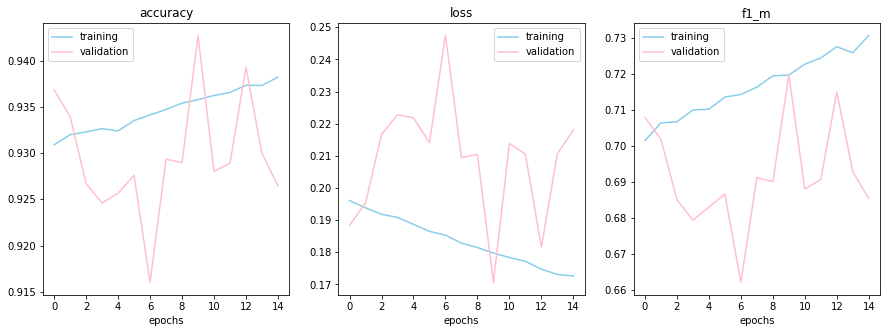

In [70]:
# Grafici koji prikazuju promene metrika tokom treniranja na trening skupu i validacionom skupu kroz epohe 

plot_graphs(binary_history, ['accuracy', 'loss', 'f1_m'])

### 6. Evaluacija modela

In [71]:
scores = binary_model.evaluate(X_test, y_test)
print('Loss: ', scores[0])
print('Test accuracy: ', scores[1])
print('F1: ', scores[2])

2305/2305 [==============================] - 7s 3ms/step - loss: 0.2183 - accuracy: 0.9264 - f1_m: 0.6615
Loss:  0.21834060549736023
Test accuracy:  0.9264171123504639
F1:  0.6615444421768188


Predviđanje: 

In [72]:
y_predicted = binary_model.predict(X_test)

2305/2305 [==============================] - 6s 3ms/step


In [73]:
# sigmoidna funkcija:

y_labels = [int(score > 0.5) for score in y_predicted]

In [74]:
# F1 mera je bolja metrika kada su neizbalansirane klase

print('F1: ', metrics.f1_score(y_test, y_labels))

F1:  0.6996235606731621


In [75]:
cf = metrics.confusion_matrix(y_test, y_labels)
print(cf)

[[61995  4331]
 [ 1095  6319]]


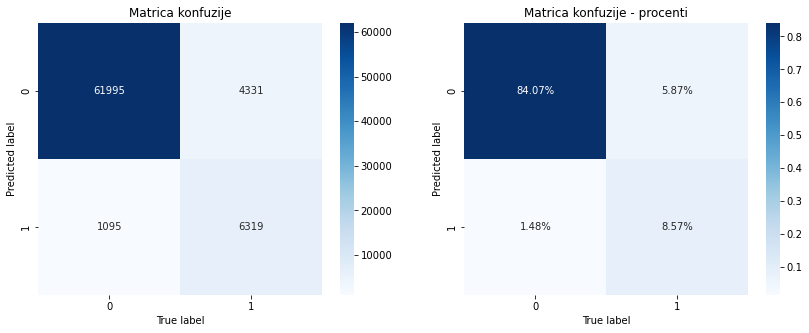

In [76]:
# funkcija koja prikazuje matricu konfuzije i 
# istu tu matricu sa vrednostima u  procentima

plot_cf(cf, 'binary', ['untoxic, toxic'])

In [77]:
y_test.value_counts()

0    66326
1     7414
Name: target, dtype: int64

In [78]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels))

---------------------- IZVESTAJ -----------------------

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     66326
           1       0.59      0.85      0.70      7414

    accuracy                           0.93     73740
   macro avg       0.79      0.89      0.83     73740
weighted avg       0.94      0.93      0.93     73740

